# Practice Session 06: PageRank

Author: <font color="black">Tània Pazos</font>

E-mail: <font color="black">tania.pazos01@estudiant.upf.edu</font>

Date: <font color="black">24/10/2023</font>

# 1. Read host names

In [1]:
import io
import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
INPUT_NODES_FILENAME = "data/webspam-uk2007/webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "data/webspam-uk2007/webspam_uk2007-edges.csv.gz"

Firsly, we read the `INPUT_NODES_FILENAME` into dictionaries `id2name`, `name2id`, and `id2label`.

In [3]:
id2name = {}
name2id = {}
id2label = {}

# Read the three mappings
with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader:
        # Convert node id to an integer
        node_id = int(record["nodeid"])
        hostname = record["hostname"]
        label = record["label"]
        
        # Fill the dictionaries
        id2name[node_id] = hostname
        name2id[hostname] = node_id
        id2label[node_id] = label

In [4]:
# Verifying
print("Number of hosts: %s" % len(id2name))
print("%s: %s" % (id2name[107471], id2label[107471]))
print("%s: %s" % (id2name[3735], id2label[3735]))

Number of hosts: 114529
www.ucl.ac.uk: unlabeled
ibiza-tickets.co.uk: spam


Next, we print how many hosts and what percentage have label `spam`, `nonspam`, and `unlabeled`.

In [5]:
# Calculate number of spam, nonspam, and unlabeled hosts
spam_count = 0
non_spam_count = 0
unlabeled_count = 0
total = len(id2label)

for label in id2label.values():
    if label == "spam":
        spam_count += 1
    elif label == "nonspam":
        non_spam_count += 1
    elif label == "unlabeled":
        unlabeled_count += 1

per_spam = (spam_count/total) * 100
per_non_spam = (non_spam_count/total) * 100
per_unlabeled = (unlabeled_count/total) * 100

# Format numbers with thousand separators and the percentage with one decimal
print(f"spam: {spam_count:,} ({per_spam:.1f}%)")
print(f"nonspam: {non_spam_count:,} ({per_non_spam:.1f}%)")
print(f"unlabeled: {unlabeled_count:,} ({per_unlabeled:.1f}%)")

spam: 344 (0.3%)
nonspam: 5,709 (5.0%)
unlabeled: 108,476 (94.7%)


The code below creates a graph `g` containing the edges that fulfill the following three conditions:
1. The source contains one of the `spammywords` or the destination contains one of the `spammywords`
1. The source is labeled as either `spam` or `nonspam`
1. The destination is labeled as either `spam` or `nonspam`

Finally, the number of nodes in the resulting graph is printed.

In [6]:
# Define spammy words and categories
spammy_words = ['shop', 'directory', 'credit', 'mortgage', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl']

# Create the directed graph
g = nx.DiGraph()

# Go through the edges file and add edges
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as edges_file:
    
    # Create CSV reader to read the contents of the input file
    reader = csv.DictReader(edges_file, delimiter=',', quotechar='"')
  
    # Iterate through each row in the CSV file
    for edge in reader:
        source = int(edge["source"])
        destination = int(edge["destination"])
        weight = int(edge["weight"])
        
        # Check if source or destination hostname contains a spammy word
        # Check if source and destination are labeled as either spam or nonspam
        # If the answer is yes for both, add the edge
        source_hostname = id2name[source]
        destination_hostname = id2name[destination]

        if source_hostname and destination_hostname:
            source_label = id2label[source]
            destination_label = id2label[destination]

            if (
                any(word in source_hostname for word in spammy_words) or
                any(word in destination_hostname for word in spammy_words)
            ) and (
                source_label in ["spam", "nonspam"] and
                destination_label in ["spam", "nonspam"]
            ):
                g.add_edge(source_hostname, destination_hostname)
                                 
num_nodes = g.number_of_nodes()
print(f"Number of nodes in the resulting graph: {num_nodes}")

Number of nodes in the resulting graph: 166


Now, let's display the subgraph `g` created.

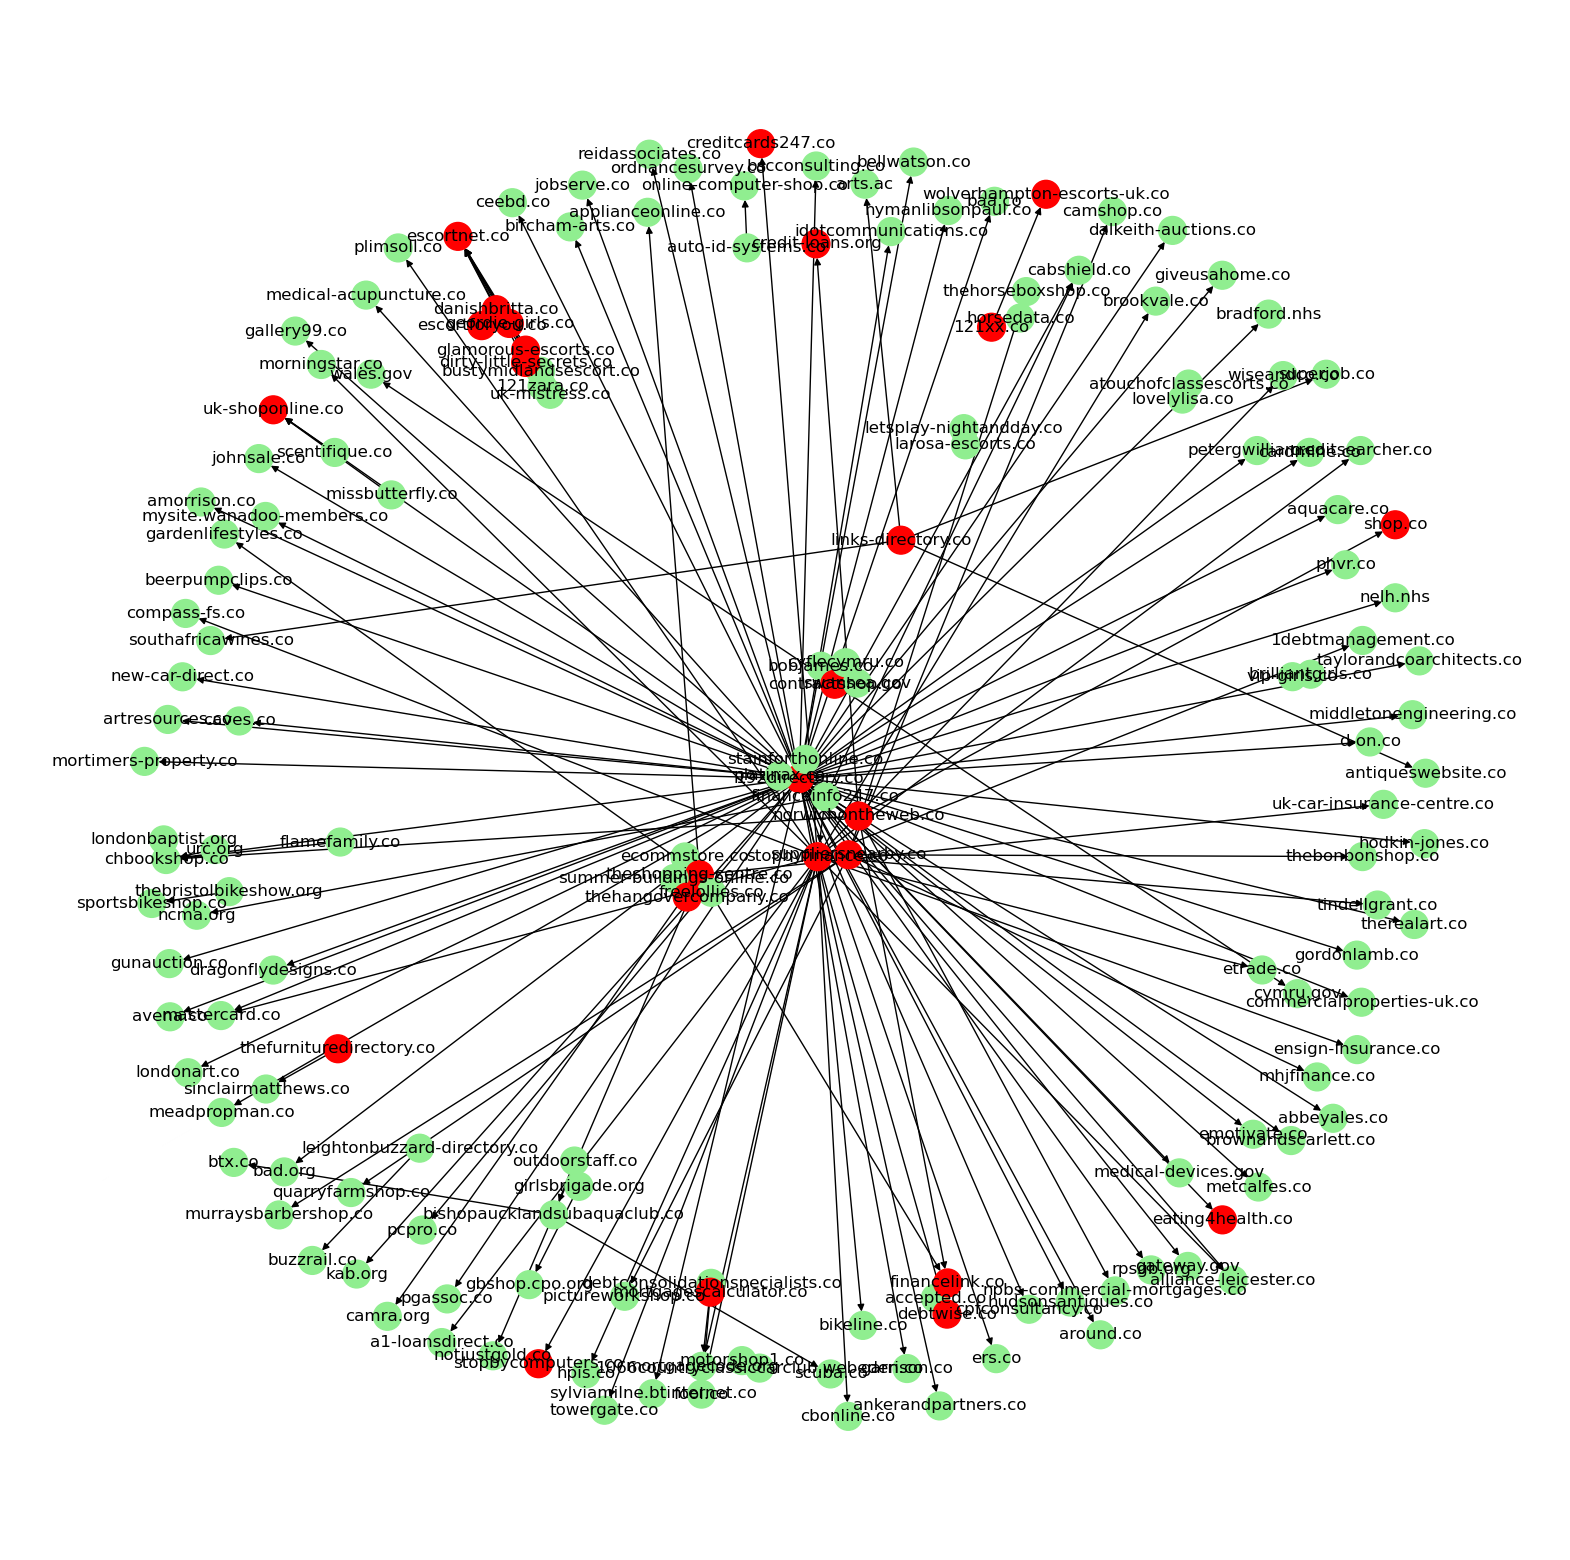

In [7]:
colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if id2label[name2id[hostname]] == 'spam':
        colors.append('red')
    elif id2label[name2id[hostname]] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')
    
    # Shorten the hostnames to generate labels    
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label
    
# If we re-run this cell the layout will be different every time
plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

First and foremost, it should be noted that there are significantly more non-spam accounts than spam ones, which confirms the percentages computed above. In addition, the vast majority of non-spam accounts are localised in the periphery of the network. Hence, they only interact with the non-spam accounts that are located in the very center, but not with other non-spam accounts in the periphery. <p>
On the other hand, spam accounts are connected to other spam accounts. What is more, spam accounts are rather central and thus act as a bridge between both spam and non-spam accounts. Indeed, spam accounts tend to point to non-spam accounts in order to desguise their condition. On the whole, spam accounts have high out-degree and low in-degree, while the peripherical non-spam accounts have out-degree 0 and in-degree 1. This could be explained because spam hosts tend to include multiple links to other malicious links in their websites. 

# 2. Compute the degree of each node

The following code computes the out-degree of each node and stores it in the `id2degree` dictionary. To do so, it first initializes the dictionary with 0 values and then reads the edges file.

In [8]:
id2degree = {}
N = len(id2name)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [9]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as edges_file:
    reader = csv.DictReader(edges_file, delimiter=',', quotechar='"')
    
    for edge in reader:
        # Identify the source node and add 1 to its degree
        source = int(edge["source"])
        id2degree[source] += 1

Now, let's verify that the file has been read correctly.

In [10]:
for nodeid in [107471, 3735, 48842]:
    print("%s: degree %d" % (id2name[nodeid], id2degree[nodeid]))

www.ucl.ac.uk: degree 1378
ibiza-tickets.co.uk: degree 1
www.financelink.co.uk: degree 5


# 3. Compute PageRank

The code below computes PageRank for every node in the graph, printing the current iteration number and the `delta` value (the sum of the absolute differences between the current iteration and the previous one).

In [11]:
# Define the number of iterations and alpha
iterations = 20
alpha = 0.92

# Initialize PageRank
pagerank = [1.0 / N] * N # Equal probabilities for each node
pagerank_aux = [0.0] * N # Auxiliary pagerank vector with zeros

# Perform iterations
for iteration in range(iterations):
    # Print current iteration number
    print("Iteration %d of %d" % (iteration + 1, iterations))
    
    # Open input file within the iteration loop
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    
        # Iterate through the edges in the input fole
        for record in reader:
            source = int(record["source"])
            destination = int(record["destination"])
            node_degree = id2degree[source]
            pagerank_aux[destination] += pagerank[source] / node_degree

    # Update PageRank with damping factor
    for i in range(N):
        pagerank[i] = alpha * pagerank_aux[i] + (1.0 - alpha) / N
    
    # Normalize
    total_pagerank = sum(pagerank)
    pagerank = [pr / total_pagerank for pr in pagerank]
    
    # Compute delta by adding the absolute differences between the previous auxiliary
    # and the current PageRank
    delta = sum(abs(pagerank[i] - pagerank_aux[i]) for i in range(N))
    print(f"Delta: {delta:.4f}")
    
    # Reset auxiliary PageRank vector to zero for next iteration
    pagerank_aux = [0.0] * N

Iteration 1 of 20
Delta: 0.4311
Iteration 2 of 20
Delta: 0.1859
Iteration 3 of 20
Delta: 0.1636
Iteration 4 of 20
Delta: 0.1437
Iteration 5 of 20
Delta: 0.1387
Iteration 6 of 20
Delta: 0.1334
Iteration 7 of 20
Delta: 0.1313
Iteration 8 of 20
Delta: 0.1291
Iteration 9 of 20
Delta: 0.1279
Iteration 10 of 20
Delta: 0.1266
Iteration 11 of 20
Delta: 0.1258
Iteration 12 of 20
Delta: 0.1250
Iteration 13 of 20
Delta: 0.1243
Iteration 14 of 20
Delta: 0.1237
Iteration 15 of 20
Delta: 0.1231
Iteration 16 of 20
Delta: 0.1225
Iteration 17 of 20
Delta: 0.1220
Iteration 18 of 20
Delta: 0.1214
Iteration 19 of 20
Delta: 0.1209
Iteration 20 of 20
Delta: 0.1203


# 4. Nodes with largest values of PageRank

Next, we create the function `print_by_pagerank` to print the 20 hosts with largest PageRank. For each host, we print its id, host name, label, and PageRank score.

In [12]:
def print_by_pagerank(pagerank):
    # Sort hosts by PageRank in descending order
    hosts_by_score = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)

    # Print top 20 hosts
    # The list below contains top 20 (index,score) pairs sorted
    top20 = hosts_by_score[:20]
    for index, score in top20:
        hostname = id2name[index]
        label = id2label[index]
        # Print hostname and PageRank score for every host
        # Format the score to print 6 decimals
        print(f"Host id: {index}, Host name: {hostname}, Label: {label}, PageRank: {score:.6f}")

In [13]:
# Test the function
print_by_pagerank(pagerank)

Host id: 81634, Host name: www.opsi.gov.uk, Label: unlabeled, PageRank: 0.006942
Host id: 60715, Host name: www.ico.gov.uk, Label: unlabeled, PageRank: 0.004037
Host id: 10990, Host name: www.adobe.co.uk, Label: unlabeled, PageRank: 0.003487
Host id: 42757, Host name: www.dti.gov.uk, Label: unlabeled, PageRank: 0.003291
Host id: 39774, Host name: www.defra.gov.uk, Label: unlabeled, PageRank: 0.003166
Host id: 65466, Host name: www.kelkoo.co.uk, Label: unlabeled, PageRank: 0.002978
Host id: 34406, Host name: www.communities.gov.uk, Label: unlabeled, PageRank: 0.002760
Host id: 40999, Host name: www.direct.gov.uk, Label: unlabeled, PageRank: 0.002752
Host id: 40559, Host name: www.dfes.gov.uk, Label: unlabeled, PageRank: 0.002621
Host id: 6475, Host name: shopping.kelkoo.co.uk, Label: unlabeled, PageRank: 0.002524
Host id: 9215, Host name: www.aa-roundabout.org.uk, Label: unlabeled, PageRank: 0.002520
Host id: 12326, Host name: www.alcoholics-anonymous.org.uk, Label: unlabeled, PageRank:

Firstly, it is worth noting that many of the websites with higher PageRank are governmental - in particular, 65% of the websites listes above. This can be attributed to the fact that Government websites provide for reliable and diverse information, which explains why other websites from multiple fields might want to link to them. <p>
Commercial sites account for the 25% of the top 20 websites with highest PageRank. If we analyse their names, however, we can observe that they do not sell a specific product, but rather offer a service. For instance, "www.kelkoo.co.uk" is a price comparator, "news.bbc.co.uk" is a news provider, and "www.nationalrail.co.uk" is UK's rail company. Hence, it seems obvious why other websites would refer to them. <p>
Finally, there are also educational sites in the list -constituting the remaining 10%- such as "www.alcoholics-anonymous.org.uk" . Indeed, alcoholism is a major problem in the UK and Alcoholics Anonymous (AA) is a reputable, worlwide organization.

# 5. Run non-spam PageRank

The code below computes the "no-spam degree" -where any link in which the source and the destination are known spam hosts is ignored- of all nodes into the dictionary `id2nsdegree`.

In [14]:
id2nsdegree = {}
for nodeid in range(N):
    id2nsdegree[nodeid] = 0 # Initialize to 0
    
# Open the input edges file
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    
    for record in reader:
        source = int(record["source"])
        destination = int(record["destination"])
        
        # Check if source and destination are not spam hosts
        if id2label[source] != "spam" and id2label[destination] != "spam":
            # Increment the no-spam degree for source node
            id2nsdegree[source] += 1

In [15]:
# Testing the code
for nodeid in [107471, 1469, 48842]:
    print("%s: normal degree %d nospam degree %d" % (id2name[nodeid], id2degree[nodeid], id2nsdegree[nodeid]))

www.ucl.ac.uk: normal degree 1378 nospam degree 1378
candycaine.skinthesun.co.uk: normal degree 22 nospam degree 20
www.financelink.co.uk: normal degree 5 nospam degree 0


The following code computes non-spam PageRank for all nodes.

In [16]:
# Define the number of iterations and alpha
iterations = 20
alpha = 0.92

# Initialize PageRank
ns_pagerank = [1.0 / N] * N # Equal probabilities for each node
ns_pagerank_aux = [0.0] * N # Auxiliary pagerank vector with zeros

# Perform iterations
for iteration in range(iterations):
    # Print current iteration number
    print("Iteration %d of %d" % (iteration + 1, iterations))
    
    # Open input file within the iteration loop
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    
        # Iterate through the edges in the input fole
        for record in reader:
            source = int(record["source"])
            destination = int(record["destination"])
            node_degree = id2nsdegree[source]
            if node_degree != 0:
                ns_pagerank_aux[destination] += ns_pagerank[source] / node_degree

    # Update PageRank with damping factor
    for i in range(N):
        ns_pagerank[i] = alpha * ns_pagerank_aux[i] + (1.0 - alpha) / N
    
    # Normalize
    total_ns_pagerank = sum(ns_pagerank)
    ns_pagerank = [pr / total_ns_pagerank for pr in ns_pagerank]
    
    # Compute delta by adding the absolute differences between the previous auxiliary
    # and the current PageRank
    delta = sum(abs(ns_pagerank[i] - ns_pagerank_aux[i]) for i in range(N))
    print(f"Delta: {delta:.4f}")
    
    # Reset auxiliary PageRank vector to zero for next iteration
    ns_pagerank_aux = [0.0] * N

Iteration 1 of 20
Delta: 0.4315
Iteration 2 of 20
Delta: 0.1860
Iteration 3 of 20
Delta: 0.1635
Iteration 4 of 20
Delta: 0.1437
Iteration 5 of 20
Delta: 0.1387
Iteration 6 of 20
Delta: 0.1334
Iteration 7 of 20
Delta: 0.1313
Iteration 8 of 20
Delta: 0.1290
Iteration 9 of 20
Delta: 0.1278
Iteration 10 of 20
Delta: 0.1265
Iteration 11 of 20
Delta: 0.1257
Iteration 12 of 20
Delta: 0.1249
Iteration 13 of 20
Delta: 0.1242
Iteration 14 of 20
Delta: 0.1236
Iteration 15 of 20
Delta: 0.1230
Iteration 16 of 20
Delta: 0.1224
Iteration 17 of 20
Delta: 0.1219
Iteration 18 of 20
Delta: 0.1213
Iteration 19 of 20
Delta: 0.1208
Iteration 20 of 20
Delta: 0.1202


Next, we print the top 20 hosts with largest non-spam PageRank scores.

In [17]:
print_by_pagerank(ns_pagerank)

Host id: 81634, Host name: www.opsi.gov.uk, Label: unlabeled, PageRank: 0.006935
Host id: 60715, Host name: www.ico.gov.uk, Label: unlabeled, PageRank: 0.004029
Host id: 10990, Host name: www.adobe.co.uk, Label: unlabeled, PageRank: 0.003482
Host id: 42757, Host name: www.dti.gov.uk, Label: unlabeled, PageRank: 0.003288
Host id: 39774, Host name: www.defra.gov.uk, Label: unlabeled, PageRank: 0.003160
Host id: 65466, Host name: www.kelkoo.co.uk, Label: unlabeled, PageRank: 0.002977
Host id: 34406, Host name: www.communities.gov.uk, Label: unlabeled, PageRank: 0.002758
Host id: 40999, Host name: www.direct.gov.uk, Label: unlabeled, PageRank: 0.002748
Host id: 40559, Host name: www.dfes.gov.uk, Label: unlabeled, PageRank: 0.002619
Host id: 6475, Host name: shopping.kelkoo.co.uk, Label: unlabeled, PageRank: 0.002523
Host id: 9215, Host name: www.aa-roundabout.org.uk, Label: unlabeled, PageRank: 0.002517
Host id: 12326, Host name: www.alcoholics-anonymous.org.uk, Label: unlabeled, PageRank:

It is clear that the differences between the regular PageRank and the non-spam PageRank scores are minimal. Indeed, it can be observed that the scores of the non-spam PageRank are slightly higher than those of the regular PageRank. This can be explained because -as the graph visualization depicts- the number of spam accounts is low compared to the number of non-spam accounts. As a result, computing the PageRank without taking into account the spam accounts does not significantly differ from computing the PageRank without account restrictions. 

# 6. Compute spam gain

The following code computes the gain of every host as (Normal PageRank) / (No spam PageRank) and prints the top 30 hosts by spam gain displaying their hostname, label, gain -with two decimals-, PageRank score, and No spam PageRank score -both with two significant digits-.

In [18]:
gains = []

# List of (index, gain)
for i in range(N):
    gain = pagerank[i] / ns_pagerank[i]
    
    gains.append(gain)

# Sort the list in descending order
gains_sorted = sorted(enumerate(gains), key=lambda x: x[1], reverse=True)

# Print the top 30 hosts by gain
top30 = gains_sorted[:30]
for index, gain in top30:
    hostname = id2name[index]
    label = id2label[index]
    
    # Format PageRank and No spam Page Rank with two significant digits
    # and gain with two decimals
    print(f"Hostname: {hostname}, Label: {label}, Gain: {gain: .2f}, PageRank: {pagerank[index]: .1e}, No spam PageRank: {ns_pagerank[index]: .1e}")

Hostname: www.aili.co.uk, Label: unlabeled, Gain:  116.08, PageRank:  1.1e-04, No spam PageRank:  9.6e-07
Hostname: www.into.demon.co.uk, Label: spam, Gain:  30.80, PageRank:  1.0e-04, No spam PageRank:  3.3e-06
Hostname: sport.uk-shoponline.co.uk, Label: unlabeled, Gain:  14.32, PageRank:  1.1e-05, No spam PageRank:  8.0e-07
Hostname: hosting3.123-reg.co.uk, Label: spam, Gain:  9.82, PageRank:  7.8e-06, No spam PageRank:  7.9e-07
Hostname: www.mercurywd.co.uk, Label: spam, Gain:  4.42, PageRank:  1.2e-05, No spam PageRank:  2.7e-06
Hostname: www.phones4uk.co.uk, Label: unlabeled, Gain:  4.30, PageRank:  6.3e-06, No spam PageRank:  1.5e-06
Hostname: www.funkidry.co.uk, Label: unlabeled, Gain:  3.36, PageRank:  3.8e-06, No spam PageRank:  1.1e-06
Hostname: www.timcointernet.co.uk, Label: spam, Gain:  3.13, PageRank:  4.1e-06, No spam PageRank:  1.3e-06
Hostname: www.buy-cheap.co.uk, Label: unlabeled, Gain:  3.11, PageRank:  1.5e-05, No spam PageRank:  4.9e-06
Hostname: www.adagio-escort

The vast majority of the top 30 hosts with higher spam gain are commercial sites. It is difficult to identify the product or service that these companies are offering, since some contain dubious, spammy names such as "www.into.demon.co.uk" or "www.bannockburnrda.org.uk". Nevertheless, there are also some legitimate-looking websites in the list, like "www.free-book.co.uk". This can be explained because, even though the accounts that generally benefit from spammy or illegitimate sources are spam accounts, legitimate accounts are often pointed to by spam accounts to cover their illegitimacy -as can be observed in the graph visualization above. <p>
Consequently, using the non-spam PageRank to compute PageRank scores reduces the influence of spammy hosts on the PageRank of websites, i.e., the PageRank values obtained are more trustworthy. Furthermore, it allows for the detection of spammy websites, which will have a significantly lower No spam PageRank score.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>